In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from DataHandlers.importer_snippets import biologic_mpt_voltammetry
from DataHandlers.LinReg import PolyReg
from scipy import interpolate
import os
plt.style.use("JGW-PPT")

# plt.rcParams["figure.figsize"] = (8,6)
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\DataHandlers\\notebooks\\JaramilloGroup'

In [7]:
dir_name = r"C:\Users\jgage\OneDrive - Stanford\Jaramillo Group\EC-data\GC-Control-1.5mm_JGW2-08"
technique = 'CVA'

data_frames = {}
for file in os.listdir(dir_name):
    if file.endswith(".mpt"):
        if technique in str(file):
            path = os.path.join(dir_name, file)
            df = biologic_mpt_voltammetry(path)
            data_frames[file] = df
            # print(str(file)[:-4] + '.csv')
            # df.to_csv(str(path)[:-4] + '.csv')
            print(file)

1200rpm_JGW2-08-11_04_CVA_C01.mpt
1600rpm_JGW2-08-12_04_CVA_C01.mpt
400rpm_JGW2-08-04_04_CVA_C01.mpt
400rpm_JGW2-08-05_04_CVA_C01.mpt
400rpm_JGW2-08-06_04_CVA_C01.mpt
400rpm_JGW2-08-09_04_CVA_C01.mpt
800rpm_JGW2-08-07_04_CVA_C01.mpt
800rpm_JGW2-08-10_04_CVA_C01.mpt


In [8]:
selected_files = ['400rpm_JGW2-08-09_04_CVA_C01.mpt', '800rpm_JGW2-08-10_04_CVA_C01.mpt',
                  '1200rpm_JGW2-08-11_04_CVA_C01.mpt', '1600rpm_JGW2-08-12_04_CVA_C01.mpt']
rpm_series = []
for i in selected_files:
    rpm_series.append(data_frames[i])

# rpm_series[0]

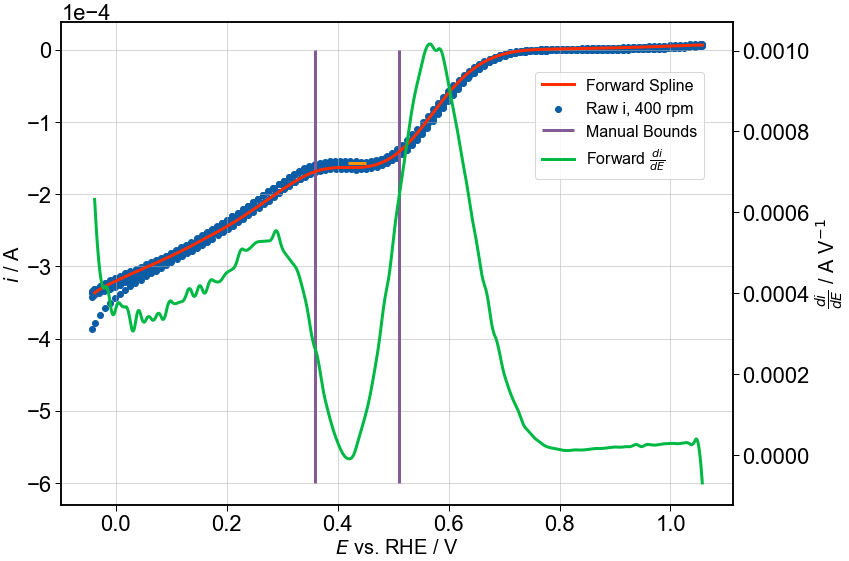

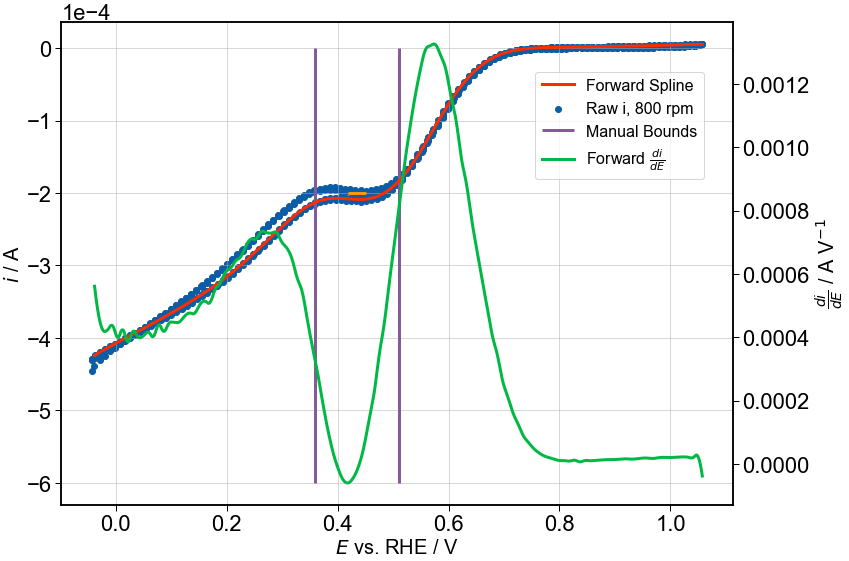

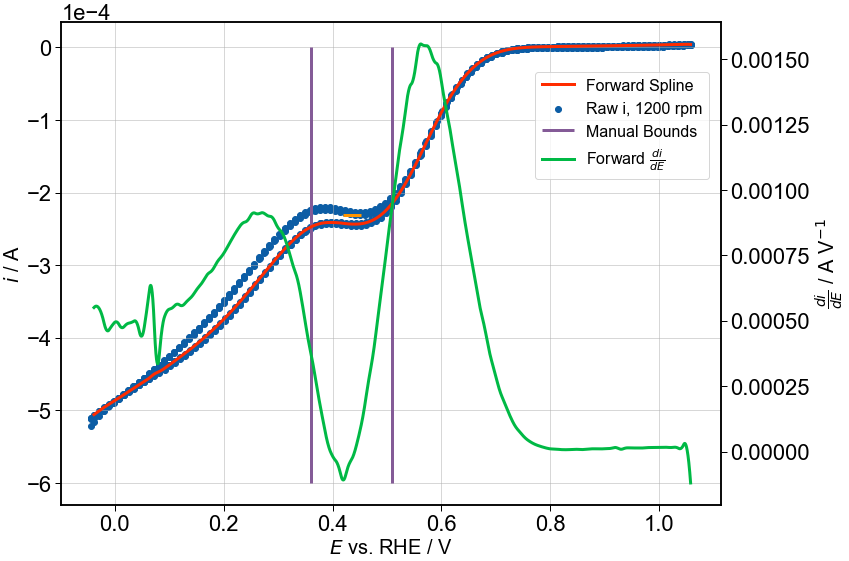

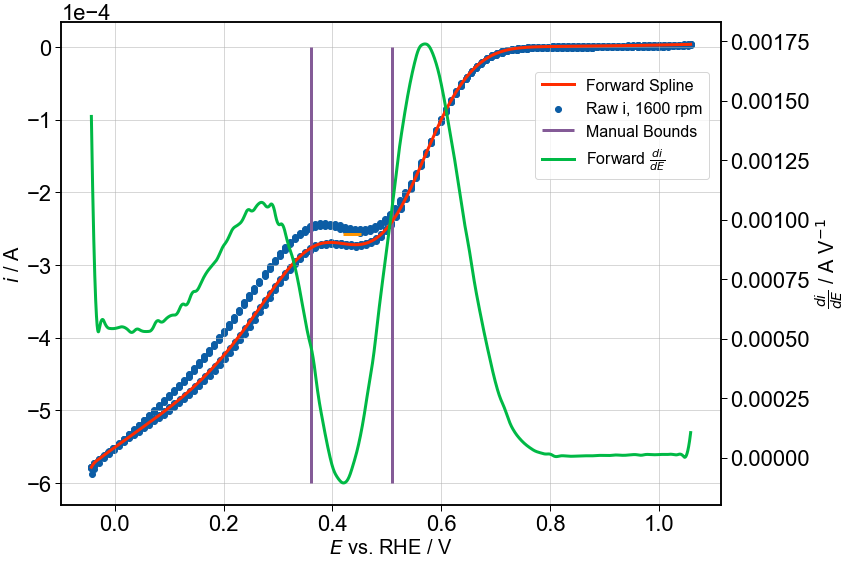

In [24]:
labels = ['400 rpm', '800 rpm', '1200 rpm', '1600 rpm']
selected_cycle = 2
ilc_est = []

for i in range(len(rpm_series)):
    # Separate forward and reverse scans
    scan_direction_bools = []
    for k in range(len(rpm_series[i]['Ewe/V'])):
        if k == 0:
            scan_direction_bools.append(True)
        elif rpm_series[i]['Ewe/V'][k - 1]  < rpm_series[i]['Ewe/V'][k]:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)

    rpm_series[i]['forward'] = scan_direction_bools

smooth = 0
for i in range(len(rpm_series)):
    # Convert to RHE, current in Amps
    rpm_series[i]['E vs RHE'] = rpm_series[i]['Ewe/V'] + 0.958
    rpm_series[i]['<I>/A'] = rpm_series[i]['<I>/mA'] / 1000

    # Filter for cycle number
    cycle_df = rpm_series[i].loc[rpm_series[i]['cycle number'] == selected_cycle]


    xf, yf = cycle_df.loc[cycle_df['forward'] == True]['E vs RHE'], cycle_df.loc[cycle_df['forward'] == True]['<I>/A']
    xr, yr = cycle_df.loc[cycle_df['forward'] == False]['E vs RHE'], cycle_df.loc[cycle_df['forward'] == False]['<I>/A']

    tck = interpolate.splrep(xf, yf, k=3, s=smooth)
    x_spline = np.linspace(np.min(xf), np.max(xf), 10000)
    y_spline = interpolate.splev(x_spline, tck, der=0)
    y_spline_1der = interpolate.splev(x_spline, tck, der=1)
    y_spline_2der = interpolate.splev(x_spline, tck, der=2)

    fig, ax = plt.subplots()
    ax.scatter(rpm_series[i]['E vs RHE'], rpm_series[i]['<I>/A'], label = 'Raw i, ' + labels[i], c='C00')
    ax.plot(x_spline, y_spline, label='Forward Spline', c='C01')

    twin = ax.twinx()
    twin.plot(x_spline, y_spline_1der, c='C02', label=r'Forward $\frac{di}{dE}$')
    # ax.plot(x_spline, y_spline_2der, c='C02', label='i\'\'')

    # Check the middle region
    left_bound = .36
    right_bound = .51
    ax.vlines([left_bound, right_bound], -6.0e-4, 0, colors='C04', label='Manual Bounds')
    ilc_est.append(rpm_series[i].loc[rpm_series[i]['E vs RHE'].between(left_bound, right_bound)]['<I>/A'].mean())
    ax.scatter((left_bound+right_bound)/2, ilc_est[i], c='C03', marker='_', s=300)



    # ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.set_xlabel('$E$ vs. RHE / V')
    ax.set_ylabel('$i$ / A')
    twin.set_ylabel(r'$\frac{di}{dE}$ / A V$^{-1}$')
    twin.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.63, 0.68))
    fig.tight_layout()
    plt.show()

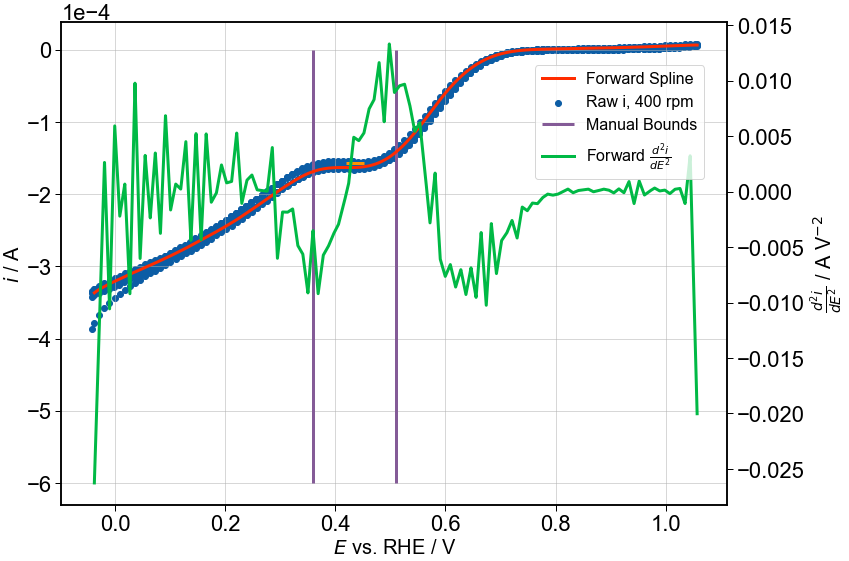

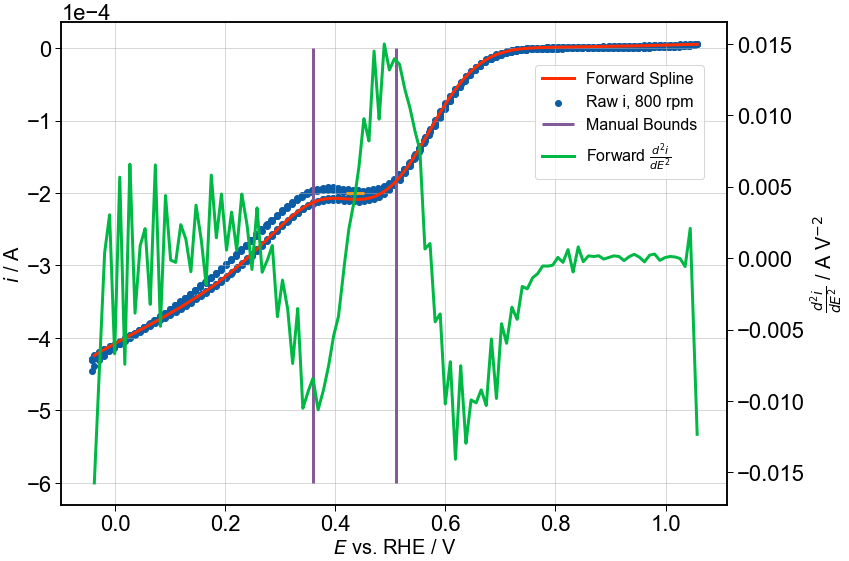

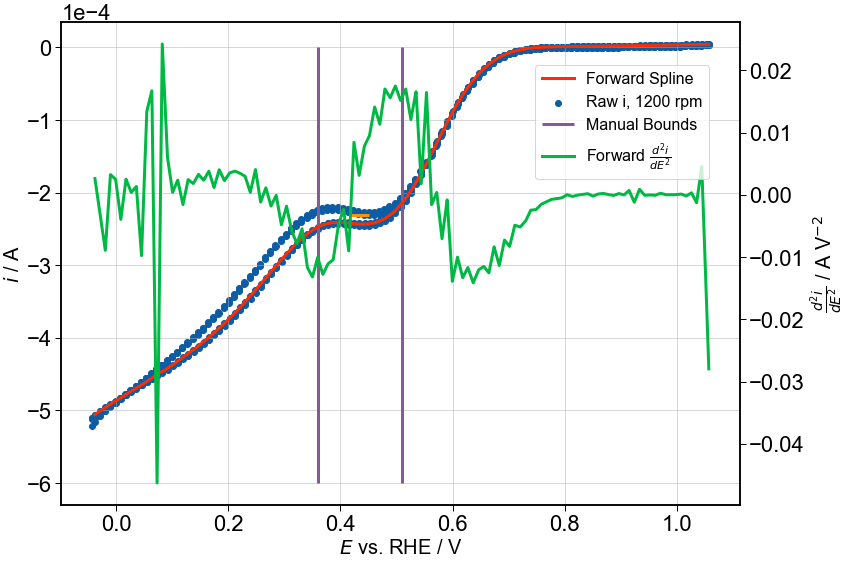

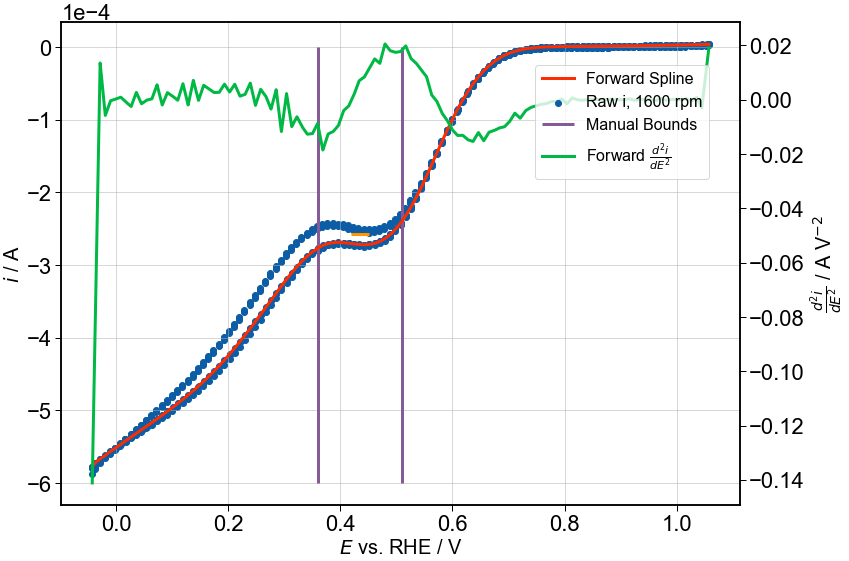

In [26]:
for i in range(len(rpm_series)):
    # Filter for cycle number
    cycle_df = rpm_series[i].loc[rpm_series[i]['cycle number'] == selected_cycle]


    xf, yf = cycle_df.loc[cycle_df['forward'] == True]['E vs RHE'], cycle_df.loc[cycle_df['forward'] == True]['<I>/A']
    xr, yr = cycle_df.loc[cycle_df['forward'] == False]['E vs RHE'], cycle_df.loc[cycle_df['forward'] == False]['<I>/A']

    tck = interpolate.splrep(xf, yf, k=3, s=smooth)
    x_spline = np.linspace(np.min(xf), np.max(xf), 10000)
    y_spline = interpolate.splev(x_spline, tck, der=0)
    y_spline_1der = interpolate.splev(x_spline, tck, der=1)
    y_spline_2der = interpolate.splev(x_spline, tck, der=2)

    fig, ax = plt.subplots()
    ax.scatter(rpm_series[i]['E vs RHE'], rpm_series[i]['<I>/A'], label = 'Raw i, ' + labels[i], c='C00')
    ax.plot(x_spline, y_spline, label='Forward Spline', c='C01')

    twin = ax.twinx()
    # twin.plot(x_spline, y_spline_1der, c='C02', label=r'$\frac{di}{dE}$')
    twin.plot(x_spline, y_spline_2der, c='C02', label=r'Forward $\frac{d^2i}{dE^2}$')

    # Check the middle region
    left_bound = .36
    right_bound = .51
    ax.vlines([left_bound, right_bound], -6.0e-4, 0, colors='C04', label='Manual Bounds')
    ilc_est.append(rpm_series[i].loc[rpm_series[i]['E vs RHE'].between(left_bound, right_bound)]['<I>/A'].mean())
    ax.scatter((left_bound+right_bound)/2, ilc_est[i], c='C03', marker='_', s=300)

    # ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.set_xlabel('$E$ vs. RHE / V')
    ax.set_ylabel('$i$ / A')
    twin.set_ylabel(r'$\frac{d^2i}{dE^2}$ / A V$^{-2}$')
    twin.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.63, 0.68))
    fig.tight_layout()
    plt.show()